In [2]:
# pip install ollama


In [1]:
import threading
import subprocess
import time
import os

def run_ollama_serve():
    ollama_path = os.path.expandvars("%LOCALAPPDATA%\\Programs\\Ollama\\ollama.exe")
    subprocess.Popen([ollama_path, "serve"])

thread = threading.Thread(target=run_ollama_serve)
thread.start()
time.sleep(5)

# Quick test to verify it's working
from ollama import Client
client = Client()
print("Ollama server started and client connected successfully!")

Ollama server started and client connected successfully!


In [3]:
#!ollama pull llama3.2

In [4]:
#pip install obsidiantools

In [34]:
import obsidiantools.api as otools
import networkx as nx
import numpy as np
from ollama import Client
from typing import Dict, List
import os
import yaml
import frontmatter

# Initialize Ollama client
ollama_client = Client()


def create_embeddings(text: str) -> np.ndarray:
    # Get embeddings using local LLM
    response = ollama_client.embeddings(
        model='llama3.2',
        prompt=text
    )
    return np.array(response['embedding'])



def similarity_search(query: str, graph_rag: Dict[str, dict], k: int = 3) -> List[str]:
    query_embedding = create_embeddings(query)
    
    # Calculate similarities (skip nodes with empty embeddings)
    similarities = {}
    for node, data in graph_rag.items():
        if data['embedding'] is not None and len(data['embedding']) > 0:
            try:
                similarity = np.dot(query_embedding, data['embedding'])
                similarities[node] = similarity
            except ValueError:
                continue
    
    # Get top k similar nodes
    if not similarities:
        return []  # Return empty list if no valid similarities found
    return sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:k]

def retrieve_context(query: str, graph_rag: Dict[str, dict], k: int = 3) -> str:
    # Get most similar nodes
    similar_nodes = similarity_search(query, graph_rag, k)
    if not similar_nodes:
        return "No relevant context found."
    
    # Build context including neighbor information
    context = []
    for node, similarity in similar_nodes:
        if node in graph_rag and 'content' in graph_rag[node]:
            context.append(f"\nNode: {node}\nContent: {graph_rag[node]['content'][:500]}...")  # Limit content length
            
            # Add information about connected nodes
            if 'neighbors' in graph_rag[node]:
                neighbors = graph_rag[node]['neighbors'][:5]  # Limit to first 5 neighbors
                context.append(f"Connected to: {', '.join(neighbors)}\n")
    
    return "\n".join(context)




# Initialize graph RAG system
vault_path = "C:/Users/andre/.cursor/cognitive/"

In [23]:
import obsidiantools.api as otools
import networkx as nx
import numpy as np
from ollama import Client
from typing import Dict, List
import os
import yaml
import frontmatter
import re

def clean_markdown_content(content: str) -> str:
    """Clean markdown content by removing or fixing common YAML issues."""
    # If content starts with ---, ensure proper YAML frontmatter format
    if content.startswith('---'):
        try:
            # Split by --- to separate frontmatter and content
            parts = content.split('---', 2)
            if len(parts) >= 3:
                # Keep the content part only
                return parts[2].strip()
            return content
        except:
            return content
    return content

def load_obsidian_graph(vault_path: str, print_node_add: bool = False) -> tuple[nx.Graph, Dict[str, str]]:
    G = nx.Graph()
    nodes_content = {}
    
    print(f"Scanning directory: {vault_path}")
    
    # First pass: Load all files and create nodes
    md_files = []
    for root, _, files in os.walk(vault_path):
        for file in files:
            if file.endswith('.md'):
                file_path = os.path.join(root, file)
                md_files.append((file, file_path))
                
    print(f"Found {len(md_files)} markdown files")
    
    # Second pass: Process files and find links
    for file, file_path in md_files:
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                content = f.read()
                
            # Clean content
            cleaned_content = clean_markdown_content(content)
            
            # Create node (without extension)
            node_name = os.path.splitext(file)[0]
            nodes_content[node_name] = cleaned_content
            G.add_node(node_name)
            
            if print_node_add:
                print(f"Added node: {node_name}")
            
            # Find wiki-style links [[link]]
            links = re.findall(r'\[\[(.*?)\]\]', cleaned_content)
            
            # Add edges for each link
            for link in links:
                # Remove any #header-links and take just the page name
                link = link.split('#')[0].split('|')[0].strip()
                if link:  # if link is not empty
                    G.add_edge(node_name, link)
                    if print_node_add:
                        print(f"  Added edge: {node_name} -> {link}")
            
        except Exception as e:
            print(f"Warning: Error processing {file}: {str(e)}")
    
    print(f"\nGraph Summary:")
    print(f"Nodes: {G.number_of_nodes()}")
    print(f"Edges: {G.number_of_edges()}")
    
    return G, nodes_content

G, nodes_content = load_obsidian_graph(vault_path, print_node_add=True)

Scanning directory: C:/Users/andre/.cursor/cognitive/
Found 235 markdown files
Added node: InferAnt_Stream_10
Added node: project_structure
Added node: README
  Added edge: README -> active_inference
  Added edge: README -> obsidian_linking
  Added edge: README -> active_inference
  Added edge: README -> knowledge_organization
  Added edge: README -> cognitive_phenomena
  Added edge: README -> ai_folder_structure
  Added edge: README -> ai_concept_template
  Added edge: README -> documentation_standards
  Added edge: README -> testing_guide
  Added edge: README -> obsidian_linking
  Added edge: README -> linking_completeness
  Added edge: README -> ai_concept_template
  Added edge: README -> ai_validation_framework
  Added edge: README -> active_inference
  Added edge: README -> belief_updating
  Added edge: README -> action_selection
  Added edge: README -> predictive_processing
  Added edge: README -> network_analysis
  Added edge: README -> quality_metrics
  Added edge: README -> vi


Generating visualizations...


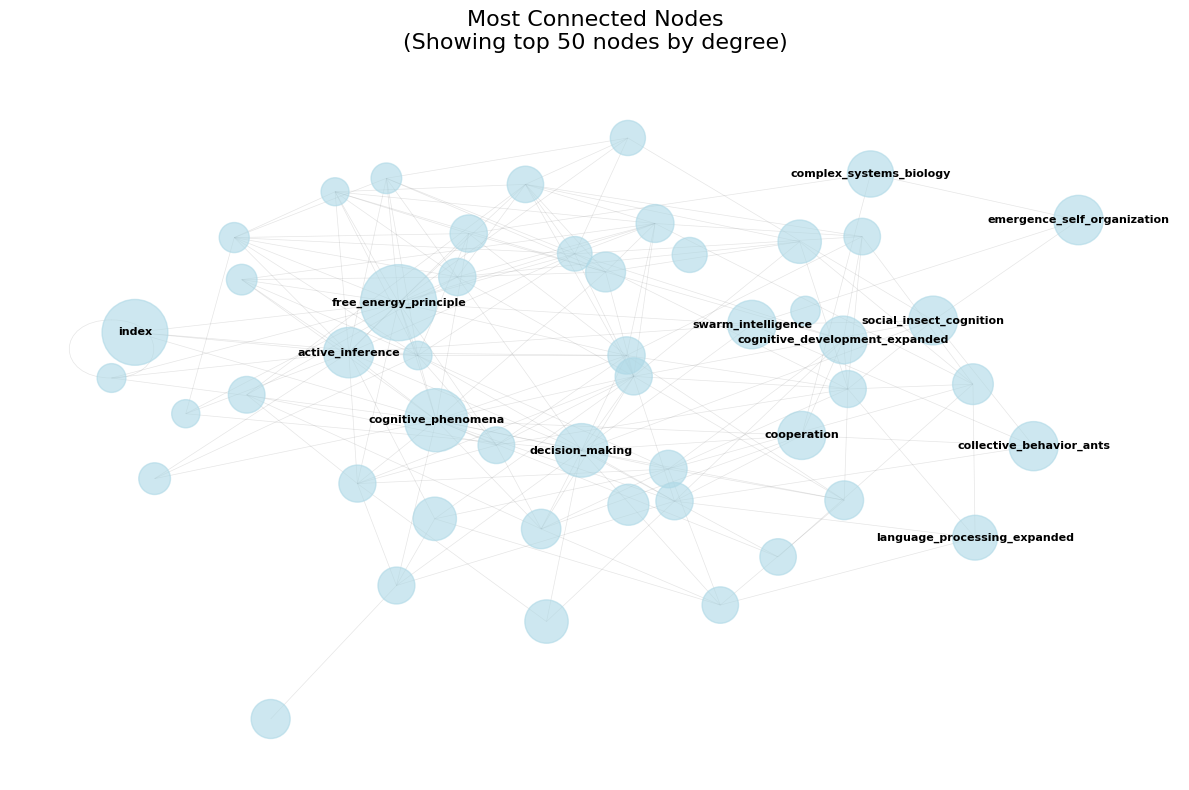

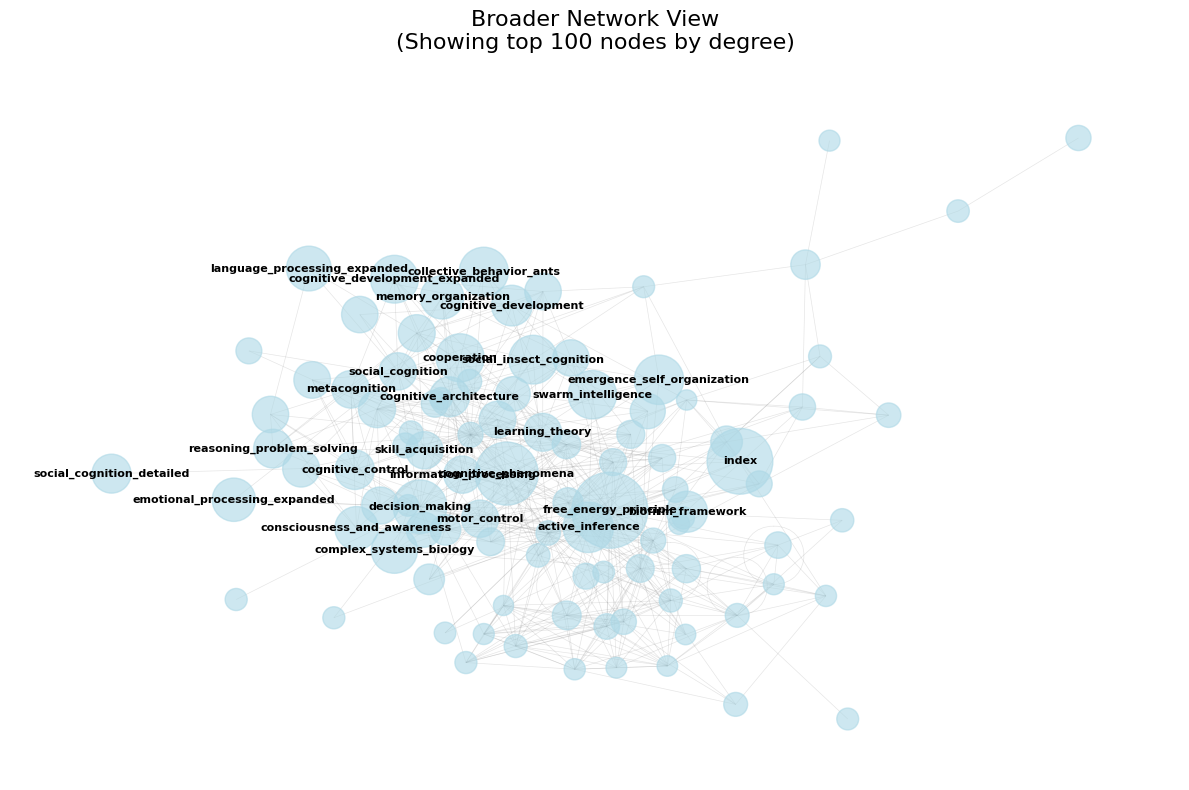

Graph Statistics:
Number of nodes: 8429
Number of edges: 13302

Degree Statistics:
Average degree: 3.16
Max degree: 628

Most connected nodes:
free_energy_principle: 628 connections
index: 470 connections
cognitive_phenomena: 432 connections
decision_making: 312 connections
active_inference: 276 connections

Connected Components: 25
Average clustering coefficient: 0.078


In [28]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def print_graph_stats(G: nx.Graph):
    """Print various statistics about the graph."""
    print(f"Graph Statistics:")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    
    if G.number_of_nodes() > 0:
        print(f"\nDegree Statistics:")
        degrees = [d for n, d in G.degree()]
        print(f"Average degree: {sum(degrees)/len(degrees):.2f}")
        print(f"Max degree: {max(degrees)}")
        
        print(f"\nMost connected nodes:")
        sorted_nodes = sorted(G.degree(), key=lambda x: x[1], reverse=True)
        for node, degree in sorted_nodes[:5]:
            print(f"{node}: {degree} connections")
        
        print(f"\nConnected Components: {nx.number_connected_components(G)}")
        
        try:
            print(f"Average clustering coefficient: {nx.average_clustering(G):.3f}")
        except:
            print("Could not calculate clustering coefficient")

def visualize_graph(G: nx.Graph, title: str = "Knowledge Graph", max_nodes: int = 100, figsize=(12, 8)):
    """
    Visualize the NetworkX graph, optimized for large graphs by showing only the most connected nodes.
    
    Args:
        G: NetworkX graph
        title: Title for the visualization
        max_nodes: Maximum number of nodes to show
        figsize: Figure size tuple
    """
    plt.figure(figsize=figsize)
    
    # Get the most connected nodes
    degrees = dict(G.degree())
    sorted_nodes = sorted(degrees.items(), key=lambda x: x[1], reverse=True)
    top_nodes = [node for node, degree in sorted_nodes[:max_nodes]]
    
    # Create subgraph of most connected nodes
    subgraph = G.subgraph(top_nodes)
    
    # Calculate node sizes based on degree centrality (normalized)
    node_sizes = [degrees[node] * 100 for node in subgraph.nodes()]
    max_size = max(node_sizes) if node_sizes else 1
    node_sizes = [size/max_size * 3000 for size in node_sizes]
    
    # Use kamada_kawai_layout or fall back to spring_layout
    try:
        pos = nx.kamada_kawai_layout(subgraph)
    except:
        pos = nx.spring_layout(subgraph, k=1, iterations=50)
    
    # Draw the network
    nodes = nx.draw_networkx_nodes(subgraph, pos,
                                 node_color='lightblue',
                                 node_size=node_sizes,
                                 alpha=0.6)
    
    edges = nx.draw_networkx_edges(subgraph, pos,
                                 edge_color='gray',
                                 alpha=0.2,
                                 width=0.5)
    
    # Add labels only for nodes with high degree
    if sorted_nodes:
        degree_threshold = sorted_nodes[min(len(sorted_nodes)-1, max_nodes//4)][1]
        labels = {node: node for node in subgraph.nodes() 
                 if degrees[node] >= degree_threshold}
    else:
        labels = {node: node for node in subgraph.nodes()}
    
    nx.draw_networkx_labels(subgraph, pos,
                          labels=labels,
                          font_size=8,
                          font_weight='bold')
    
    plt.title(f"{title}\n(Showing top {max_nodes} nodes by degree)", 
              fontsize=16, pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize with different numbers of nodes
print("\nGenerating visualizations...")
visualize_graph(G, title="Most Connected Nodes", max_nodes=50)  # Show top 50 nodes
visualize_graph(G, title="Broader Network View", max_nodes=100)  # Show top 100 nodes

# Print graph statistics
print_graph_stats(G)

In [24]:
def build_graph_rag(G: nx.Graph, nodes_content: Dict[str, str]) -> Dict[str, dict]:
    # Create knowledge graph with embeddings
    graph_rag = {}
    
    for node, content in nodes_content.items():
        # Get node neighbors
        neighbors = list(G.neighbors(node))
        
        # Create node representation
        graph_rag[node] = {
            'content': content,
            'embedding': create_embeddings(content),
            'neighbors': neighbors
        }
    
    return graph_rag

graph_rag = build_graph_rag(G, nodes_content)
    
#     # Query the system
#     query = "What are the main concepts in my knowledge graph?"
#     answer = query_graph_rag(query, graph_rag)
#     print(answer) 

In [29]:
print(graph_rag)

{'InferAnt_Stream_10': {'content': '# InferAnt Stream 10: Active Inference - Modeling, Learning, and Exploration\n\n## Stream Information\n\n- **Platform**: GitHub Live\n- **Repository**: <https://github.com/docxology/cognitive>\n- **Tools**:\n  - Obsidian: <https://obsidian.md/>\n  - CodeViz: <https://codeviz.ai/>\n\n## Agenda\n\n### 2. Theoretical Foundations\n\n- Active Inference Framework\n  - Free Energy Principle review\n  - Generative models\n  - Belief updating\n  - Policy selection\n- Learning and Exploration\n  - Epistemic value\n  - Expected free energy\n  - Exploration-exploitation balance\n  - Information gain\n\n### 3. Implementation Architecture\n\n- POMDP (simple and generic), Ants, Biofirms\n- CodeViz and More. \n- Core Components\n  - GenerativeModel class\n  - BeliefUpdater class\n  - PolicySelector class\n  - FreeEnergyCalculator class\n- Matrix Requirements\n  - A matrix (observation mapping)\n  - B matrix (transition dynamics)\n  - C matrix (preference encoding)\n

In [37]:
def query_graph_rag(query: str, graph_rag: Dict[str, dict]) -> str:
    """Query the graph RAG system."""
    try:
        # Get relevant context
        context = retrieve_context(query, graph_rag)
        
        # Format prompt with context
        prompt = f"""Based on the following context from a knowledge graph:

{context}

Question: {query}

Please provide a clear and concise answer based only on the information in the context above."""
        
        # Get response from LLM using correct parameters
        response = ollama_client.chat(
            model='llama3.2',
            messages=[
                {
                    'role': 'user',
                    'content': prompt
                }
            ]
        )
        
        return response['message']['content']
    except Exception as e:
        return f"Error querying the graph: {e}"

# Query the system
query = "how does the B matrix relate to cognitive phenomena?"
answer = query_graph_rag(query, graph_rag)
print(answer)

There is no direct mention of the "B" matrix in relation to cognitive phenomena in the provided context. The context focuses on different mathematical concepts such as active inference theory, variational calculus, and free-energy principle, but does not explicitly define or discuss the "B" matrix.
